## Q-learning

This notebook will guide you through implementation of vanilla Q-learning algorithm.

You need to implement QLearningAgent (follow instructions for each method) and use it on a number of tests below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from collections import defaultdict
import random
import math
import numpy as np


class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value

        Note: please avoid using self._qValues directly.
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        # найкраще Q-value
        value = max(self.get_qvalue(state, action) for action in possible_actions)

        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        # за формулою сімома рядками вище
        Q_value = (1 - learning_rate) * self.get_qvalue(state, action) + learning_rate * (reward + gamma * self.get_value(next_state))

        self.set_qvalue(state, action, Q_value)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values).
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # найкраща з усіх можливих
        best_action = max(possible_actions, key=lambda action: self.get_qvalue(state, action))

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list).
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        # epsilon-greedy стратегія для вирішення exploration-exploitation дилеми:
        # з імовірністю epsilon зробимо випадкову дію;
        # з імовірністю 1-epsilon зробимо дію, результат якої нам вже відомий
        if np.random.uniform() < epsilon:  # якшо випадкове число менше епсилона, робимо випадкову дію
            chosen_action = np.random.choice(possible_actions)
        else:
            chosen_action = self.get_best_action(state)  # інакше робимо найкращу з тих, які відомі

        return chosen_action

### Try it on taxi

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [3]:
import gym
env = gym.make("Taxi-v3")

n_actions = env.action_space.n

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
agent = QLearningAgent(alpha=0.5,
                       epsilon=0.25,
                       discount=0.99,
                       get_legal_actions=lambda s: range(n_actions))

In [5]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function should
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        # train (update) agent for state s
        agent.update(s,a,r,next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

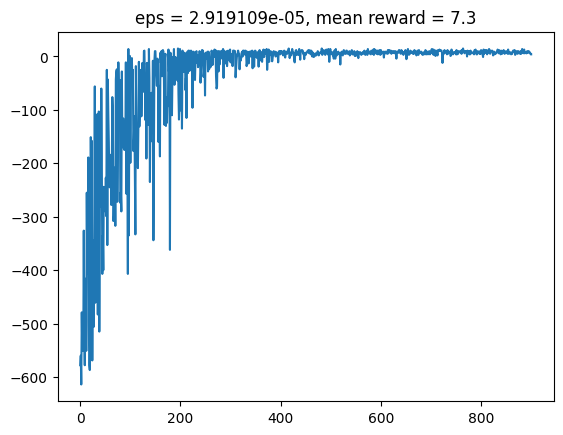

In [6]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        plt.title('eps = {:e}, mean reward = {:.1f}'.format(agent.epsilon, np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.show()